In [ ]:
import numpy as np

# 🧠 Solving the Infinite-Horizon HJB for Market Making

We compute the optimal bid and ask spreads that:

- Maximize expected utility of terminal wealth  
- Balance inventory risk and market opportunity  
- React to signals (price, imbalance, volatility)  

We solve a **stationary infinite-horizon HJB equation** to get the value function.


## 🧮 Step 1: Define Variables

### 🔢 State Variables (dynamically evolving)

Let the state be a tuple: $(q, s, z, \sigma)$

- $q$: Inventory  
- $s$: Midprice  
- $z$: Order imbalance  
- $\sigma$: Volatility  

---

### ⚙️ Control Variables

- $\delta_b$: Bid spread from midprice → quote at $s - \delta_b$  
- $\delta_a$: Ask spread from midprice → quote at $s + \delta_a$


### 📈 Market Parameters

- $\lambda_b(\delta_b) = A e^{-k \delta_b}$: Buy arrival rate  
- $\lambda_a(\delta_a) = A e^{-k \delta_a}$: Sell arrival rate  
- $\mu(s, z, \sigma)$: Drift of midprice  
- $\sigma$: Local volatility (state variable)


### 🎯 Utility and Value Function

We use exponential utility of terminal wealth:

$$
u(t, x, q, s) = -\exp\left(-\gamma\left(x + q s + \phi(q, s, z, \sigma)\right)\right)
$$

- $x$: Cash (drops out of control problem)  
- $\phi(q, s, z, \sigma)$: Value function to solve for


## 📘 Step 2: The HJB Equation

In the stationary infinite-horizon case (no $\partial_t \phi$):

$$
0 = \mu(s, z, \sigma) \frac{\partial \phi}{\partial s}
+ \frac{1}{2} \sigma^2 \frac{\partial^2 \phi}{\partial s^2}
+ J_{\text{bid}} + J_{\text{ask}}
$$


## 📈 Including Volatility as a State Variable

Volatility $\sigma$ affects the risk of quoting and the optimal spread.

### ✅ Add volatility dynamics to the HJB:
If $\sigma$ follows an SDE like:
$$ d\sigma = \eta(\sigma)\,dt + \nu(\sigma)\,dW_t $$
Then the HJB gains two new terms:
$$ \eta(\sigma)\, \frac{\partial \phi}{\partial \sigma} + \frac{1}{2} \nu^2(\sigma) \frac{\partial^2 \phi}{\partial \sigma^2} $$

### ✅ The full HJB:
$$ \begin{aligned}
0 = &\ \mu(s, z, \sigma) \frac{\partial \phi}{\partial s}
+ \frac{1}{2} \sigma^2 \frac{\partial^2 \phi}{\partial s^2} \\
&+ \eta(\sigma) \frac{\partial \phi}{\partial \sigma}
+ \frac{1}{2} \nu^2(\sigma) \frac{\partial^2 \phi}{\partial \sigma^2} \\
&+ J_{\text{bid}} + J_{\text{ask}}
\end{aligned} $$

### ✅ Update optimal spreads:
$$ \delta_b^* = \phi(q+1, s, z, \sigma) - \phi(q, s, z, \sigma) + C $$
$$ \delta_a^* = -\left(\phi(q-1, s, z, \sigma) - \phi(q, s, z, \sigma)\right) + C $$

### ✅ Discretize $\sigma$:
- Use finite differences for $\partial_\sigma \phi$ and $\partial^2_{\sigma\sigma} \phi$
- Result: a 4D grid $\phi[q][s][z][\sigma]$


### 🔁 Jump Terms

$$
J_{\text{bid}} = \lambda_b(\delta_b) \left[
\exp\left(-\gamma(\delta_b + \phi(q+1) - \phi(q))\right) - 1
\right]
$$

$$
J_{\text{ask}} = \lambda_a(\delta_a) \left[
\exp\left(-\gamma(-\delta_a + \phi(q-1) - \phi(q))\right) - 1
\right]
$$


### 🧮 Optimal Spreads

$$
\delta_b^* = \phi(q+1, s, z, \sigma) - \phi(q, s, z, \sigma) + C
$$

$$
\delta_a^* = -\left(\phi(q-1, s, z, \sigma) - \phi(q, s, z, \sigma)\right) + C
$$

Where:

$$
C = \frac{1}{\gamma} \log\left(\frac{k + \gamma}{k}\right)
$$


## 🔧 Step 3: Numerical Value Iteration

1. Discretize $q, s, z, \sigma$  
2. Initialize grid $\phi[q][s][z][\sigma]$  
3. Repeat until convergence:
   - For each grid point:
     - Compute $\delta_b, \delta_a$
     - Compute jump terms $J_{\text{bid}}, J_{\text{ask}}$
     - Approximate $\partial_s \phi$ and $\partial^2_{ss} \phi$ via finite differences
     - Evaluate HJB:
     
       $$
       HJB = \mu \frac{\partial \phi}{\partial s} + \frac{1}{2} \sigma^2 \frac{\partial^2 \phi}{\partial s^2} + J_{\text{bid}} + J_{\text{ask}}
       $$

     - Update:

       $$
       \phi_{\text{new}} = \phi - \alpha \cdot HJB
       $$
4. Measure:

   $$
   \text{max\_diff} = \max \left|\phi_{\text{new}} - \phi\right|
   $$

   Stop if $\text{max\_diff} < \varepsilon$


## 📤 Step 4: Extract Control Policy

After convergence:

$$
\delta_b(q, s, z, \sigma) = \phi(q+1) - \phi(q) + C
$$

$$
\delta_a(q, s, z, \sigma) = -(\phi(q-1) - \phi(q)) + C
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.01     # Diffusion coefficient
L = 1.0          # Length of rod
T = 0.5          # Final time
nx = 50          # Number of spatial points
nt = 2000        # Number of time steps
dx = L / (nx - 1)
dt = T / nt

# Stability check
assert alpha * dt / dx**2 <= 0.5, "Time step too large for stability!"

# Discrete grid
x = np.linspace(0, L, nx)
u = np.sin(np.pi * x)           # Initial condition
u[0] = u[-1] = 0                 # Boundary conditions

# Solution storage
all_u = [u.copy()]

# Time stepping
for n in range(nt):
    u_new = u.copy()
    for i in range(1, nx - 1):
        u_new[i] = u[i] + alpha * dt / dx**2 * (u[i+1] - 2*u[i] + u[i-1])
    u = u_new
    all_u.append(u.copy())

# Plot the solution at different times
plt.figure(figsize=(8,5))
for i in [0, int(nt/4), int(nt/2), int(3*nt/4), nt]:
    plt.plot(x, all_u[i], label=f't={i*dt:.2f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('1D Heat Equation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grid
N = 100
x = np.linspace(-1, 1, N)
dx = x[1] - x[0]
u = np.abs(x)  # Initial guess = known true solution

# Iterative solver
for _ in range(1000):
    u_new = u.copy()
    for i in range(1, N-1):
        # Approximate ∂u/∂x using upwind
        du_dx = max((u[i] - u[i-1])/dx, (u[i+1] - u[i])/dx)
        H = du_dx - 1
        u_new[i] = u[i] - 0.5 * H * dx  # Explicit Euler update
    u = u_new

# Plot
plt.plot(x, np.abs(x), label="Exact |x|")
plt.plot(x, u, '--', label="Numerical solution")
plt.grid(True)
plt.legend()
plt.title("Nonsmooth viscosity solution: u(x) = |x|")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_inventory_only_hjb(Q_max=10, A=1.0, k=0.1, gamma=0.1, max_iter=150000, tol=1e-7, dt_factor=10.0, mu=0.0):
    """
    Solves the inventory-only HJB equation for a market-making problem
    with an added drift term.

    Args:
        Q_max (int): Maximum absolute inventory level.
        A (float): Base intensity of order arrivals.
        k (float): Sensitivity of order arrival intensity to spread.
        gamma (float): Risk aversion parameter (cost of holding inventory).
        max_iter (int): Maximum number of iterations for value iteration.
        tol (float): Tolerance for convergence.
        dt_factor (float): A small factor for numerical stability (acts like a discount rate).
        mu (float): Drift term, representing the expected instantaneous profit/loss
                    from holding one unit of inventory.

    Returns:
        tuple: A tuple containing:
            - q_grid (numpy.ndarray): Array of inventory levels.
            - u (numpy.ndarray): Array of value function values for each inventory level.
    """
    q_grid = np.arange(-Q_max, Q_max + 1)
    N_q = len(q_grid)
    
    # Robust Initialization: Start with a parabolic shape, as expected for inventory costs
    # Add a small positive constant for robustness to prevent initial zero denominators
    u = -0.5 * gamma * q_grid**2 + 1.0 
    u_old = np.zeros_like(u)

    # print(f"Solving for mu = {mu}...") # Commented out to reduce console output during loop

    for iteration in range(max_iter):
        u_old[:] = u # Copy current u to u_old for convergence check

        # Update interior points
        for i in range(1, N_q - 1):
            q = q_grid[i]
            uq = u_old[i]
            uq_plus = u_old[i+1]
            uq_minus = u_old[i-1]

            # --- Calculate optimal bid/ask spreads ---
            # Default to very large spread (no trade) and very low rate if log arguments are problematic
            delta_bid = 1000.0 
            lambda_bid = 1e-10 

            # Ensure positive arguments for log and meaningful division for delta_bid
            if uq_plus > 0 and uq > 0: 
                arg_bid = (k + gamma) * uq / (k * uq_plus)
                if arg_bid > 0: 
                    delta_bid = (1/gamma) * np.log(arg_bid)
                    delta_bid = max(0, delta_bid) # Spreads must be non-negative
                    lambda_bid = A * np.exp(-k * delta_bid)
            
            delta_ask = 1000.0 
            lambda_ask = 1e-10 

            # Ensure positive arguments for log and meaningful division for delta_ask
            if uq_minus > 0 and uq > 0: 
                arg_ask = (k + gamma) * uq / (k * uq_minus)
                if arg_ask > 0: 
                    delta_ask = (1/gamma) * np.log(arg_ask)
                    delta_ask = max(0, delta_ask) # Spreads must be non-negative
                    lambda_ask = A * np.exp(-k * delta_ask)
            
            # --- CRITICAL UPDATE RULE for HJB ---
            # Numerator: Sum of expected future values (profit + next state value) and current cost
            # Added 'mu * q' term to account for the drift's effect on inventory value
            numerator = lambda_bid * (delta_bid + u_old[i-1]) + \
                        lambda_ask * (delta_ask + u_old[i+1]) - \
                        0.5 * gamma * q**2 + mu * q 
            
            # Denominator: Sum of rates (and dt_factor for stability)
            denominator = lambda_bid + lambda_ask + dt_factor 
            
            if denominator == 0: # Avoid division by zero if both lambdas are extremely small
                u[i] = u_old[i] # No change if no active rates
            else:
                u[i] = numerator / denominator

        # Boundary Conditions:
        # At q = -Q_max (index 0): Can only make a bid to increase inventory.
        q_min_idx = 0
        q_min = q_grid[q_min_idx]
        uq_min = u_old[q_min_idx]
        uq_min_plus = u_old[q_min_idx+1] 

        delta_bid_min = 1000.0
        lambda_bid_min = 1e-10
        if uq_min_plus > 0 and uq_min > 0:
            arg_bid_min = (k + gamma) * uq_min / (k * uq_min_plus)
            if arg_bid_min > 0:
                delta_bid_min = (1/gamma) * np.log(arg_bid_min)
                delta_bid_min = max(0, delta_bid_min)
                lambda_bid_min = A * np.exp(-k * delta_bid_min)
        
        numerator_min = lambda_bid_min * (delta_bid_min + u_old[q_min_idx+1]) - \
                        0.5 * gamma * q_min**2 + mu * q_min 
        denominator_min = lambda_bid_min + dt_factor
        
        if denominator_min == 0:
            u[q_min_idx] = u_old[q_min_idx]
        else:
            u[q_min_idx] = numerator_min / denominator_min

        # Boundary for q = Q_max (index N_q - 1): Can only make an ask to decrease inventory.
        q_max_idx = N_q - 1
        q_max = q_grid[q_max_idx]
        uq_max = u_old[q_max_idx]
        uq_max_minus = u_old[q_max_idx-1] 

        delta_ask_max = 1000.0
        lambda_ask_max = 1e-10
        if uq_max_minus > 0 and uq_max > 0:
            arg_ask_max = (k + gamma) * uq_max / (k * uq_max_minus)
            if arg_ask_max > 0:
                delta_ask_max = (1/gamma) * np.log(arg_ask_max)
                delta_ask_max = max(0, delta_ask_max)
                lambda_ask_max = A * np.exp(-k * delta_ask_max)

        numerator_max = lambda_ask_max * (delta_ask_max + u_old[q_max_idx-1]) - \
                        0.5 * gamma * q_max**2 + mu * q_max 
        denominator_max = lambda_ask_max + dt_factor

        if denominator_max == 0:
            u[q_max_idx] = u_old[q_max_idx]
        else:
            u[q_max_idx] = numerator_max / denominator_max

        # Convergence Check
        max_diff = np.max(np.abs(u - u_old))
        if max_diff < tol:
            # print(f"Converged at iteration {iteration + 1}. Max diff: {max_diff:.8f}") # Commented out for cleaner loop output
            break
        
        # if iteration % 100 == 0: # Commented out for cleaner loop output
        #     print(f"Iteration {iteration + 1}: Max diff = {max_diff:.8f}")

    else:
        print(f"Did not converge after {max_iter} iterations for mu = {mu}. Max diff: {np.max(np.abs(u - u_old))}")

    return q_grid, u

# --- Plotting Maximum Value vs. Drift ---
plt.figure(figsize=(10, 6))

# Define a range of mu values
mu_values = np.linspace(-0.1, 0.1, 50) # From -0.1 to 0.1 with 50 points
max_u_values = []
optimal_q_values = []

print("Calculating maximum value for different drift terms...")

for mu_val in mu_values:
    q_grid, u_solution = solve_inventory_only_hjb(mu=mu_val)
    
    # Find the maximum value of u and its corresponding inventory
    max_u = np.max(u_solution)
    optimal_q_idx = np.argmax(u_solution)
    optimal_q = q_grid[optimal_q_idx]

    max_u_values.append(max_u)
    optimal_q_values.append(optimal_q)

plt.plot(mu_values, max_u_values, marker='o', linestyle='-', markersize=4, label='Max Value $u(q)$')
plt.title("Maximum Value Function $u(q)$ vs. Price Drift $\mu$")
plt.xlabel("Price Drift $\mu$")
plt.ylabel("Maximum Value $u(q)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Plot Optimal Inventory vs. Drift
plt.figure(figsize=(10, 6))
plt.plot(mu_values, optimal_q_values, marker='x', linestyle='--', markersize=4, color='red', label='Optimal Inventory $q^*$')
plt.title("Optimal Inventory $q^*$ vs. Price Drift $\mu$")
plt.xlabel("Price Drift $\mu$")
plt.ylabel("Optimal Inventory $q^*$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# --- 1. Model Parameters ---
# User-defined parameters
Q_max = 5          # Maximum inventory
s_max = 10.0       # Maximum spread
z_max = 1.0        # Maximum volatility factor
gamma = 0.5      # Risk aversion parameter
sigma = 0.01       # Volatility of the mid-price
rho = -0.7         # Correlation between mid-price and volatility factor
delta = 0.05       # Discount rate
k = 0.1            # Order execution parameter
A = 1.0            # Liquidity parameter
Delta_z_b = 0.01   # Change in z for a buy order
Delta_z_a = 0.01   # Change in z for an ask order

# --- 2. Grid Parameters ---
# Discretization parameters
num_q = 2 * Q_max + 1
num_s = 101
num_z = 51

# Create the grid
q_grid = np.arange(-Q_max, Q_max + 1)
s_grid = np.linspace(0, s_max, num_s)
z_grid = np.linspace(-z_max, z_max, num_z)

# Grid steps
ds = s_grid[1] - s_grid[0]
dz = z_grid[1] - z_grid[0]

# --- 3. Functions ---
# User-defined functions for the model
def mu(z):
    return 0.01 * z

def f(z):
    return 0.1 * z

def g(z):
    return 0.05 * (1 + z**2)

# --- 4. Initialization ---
# Initialize the value function V with zeros
V = np.zeros((num_q, num_s, num_z))

# --- 5. Iteration Parameters ---
max_iter = 1000
tolerance = 1e-6
eta = A * k**(-gamma) * (k / (k - gamma))**(k - gamma)

# --- 6. Main Iteration Loop ---
for i in range(max_iter):
    V_old = V.copy()
    
    for i_q, q in enumerate(q_grid):
        for i_s, s in enumerate(s_grid):
            for i_z, z in enumerate(z_grid):
                
                # --- Derivatives (Finite Differences) ---
                # First-order derivatives
                if i_s > 0 and i_s < num_s - 1:
                    Vs = (V[i_q, i_s + 1, i_z] - V[i_q, i_s - 1, i_z]) / (2 * ds)
                elif i_s == 0:
                    Vs = (V[i_q, i_s + 1, i_z] - V[i_q, i_s, i_z]) / ds
                else: # i_s == num_s - 1
                    Vs = (V[i_q, i_s, i_z] - V[i_q, i_s - 1, i_z]) / ds

                if i_z > 0 and i_z < num_z - 1:
                    Vz = (V[i_q, i_s, i_z + 1] - V[i_q, i_s, i_z - 1]) / (2 * dz)
                elif i_z == 0:
                    Vz = (V[i_q, i_s, i_z + 1] - V[i_q, i_s, i_z]) / dz
                else: # i_z == num_z - 1
                    Vz = (V[i_q, i_s, i_z] - V[i_q, i_s, i_z - 1]) / dz
                    
                # Second-order derivatives
                if i_s > 0 and i_s < num_s - 1:
                    Vss = (V[i_q, i_s + 1, i_z] - 2 * V[i_q, i_s, i_z] + V[i_q, i_s - 1, i_z]) / ds**2
                else:
                    Vss = 0 # Neumann boundary condition

                if i_z > 0 and i_z < num_z - 1:
                    Vzz = (V[i_q, i_s, i_z + 1] - 2 * V[i_q, i_s, i_z] + V[i_q, i_s, i_z - 1]) / dz**2
                else:
                    Vzz = 0 # Neumann boundary condition
                    
                if i_s > 0 and i_s < num_s - 1 and i_z > 0 and i_z < num_z - 1:
                    Vsz = (V[i_q, i_s + 1, i_z + 1] - V[i_q, i_s - 1, i_z + 1] - V[i_q, i_s + 1, i_z - 1] + V[i_q, i_s - 1, i_z - 1]) / (4 * ds * dz)
                else:
                    Vsz = 0

                # --- HJB Equation ---
                # Interior region: |q| < Q
                if abs(q) < Q_max:
                    # Find V(q+1, s, z - Delta_z_b)
                    z_b_idx = np.argmin(np.abs(z_grid - (z - Delta_z_b)))
                    V_plus_1 = V[i_q + 1, i_s, z_b_idx]
                    
                    # Find V(q-1, s, z + Delta_z_a)
                    z_a_idx = np.argmin(np.abs(z_grid - (z + Delta_z_a)))
                    V_minus_1 = V[i_q - 1, i_s, z_a_idx]
                    
                    # Hamiltonian terms
                    Hb = -eta * V[i_q, i_s, i_z] * (V_plus_1 / V[i_q, i_s, i_z])**(k / gamma)
                    Ha = -eta * V[i_q, i_s, i_z] * (V_minus_1 / V[i_q, i_s, i_z])**(k / gamma)
                    
                    # Update V
                    V[i_q, i_s, i_z] = (1 / delta) * (
                        (gamma * q * mu(z) - 0.5 * sigma**2 * gamma**2 * q**2) * V[i_q, i_s, i_z] +
                        (-mu(z) + gamma * q * sigma**2) * Vs +
                        (-f(z)) * Vz +
                        (-0.5 * sigma**2) * Vss +
                        (-0.5 * g(z)**2) * Vzz +
                        (-rho * sigma * g(z)) * Vsz +
                        Hb + Ha
                    )
                
                # Boundary q = Q
                elif q == Q_max:
                    z_a_idx = np.argmin(np.abs(z_grid - (z + Delta_z_a)))
                    V_minus_1 = V[i_q - 1, i_s, z_a_idx]
                    Ha = -eta * V[i_q, i_s, i_z] * (V_minus_1 / V[i_q, i_s, i_z])**(k / gamma)
                    
                    V[i_q, i_s, i_z] = (1 / delta) * (
                        (gamma * q * mu(z) - 0.5 * sigma**2 * gamma**2 * q**2) * V[i_q, i_s, i_z] +
                        (-mu(z) + gamma * q * sigma**2) * Vs +
                        (-f(z)) * Vz +
                        (-0.5 * sigma**2) * Vss +
                        (-0.5 * g(z)**2) * Vzz +
                        (-rho * sigma * g(z)) * Vsz +
                        Ha
                    )

                # Boundary q = -Q
                elif q == -Q_max:
                    z_b_idx = np.argmin(np.abs(z_grid - (z - Delta_z_b)))
                    V_plus_1 = V[i_q + 1, i_s, z_b_idx]
                    Hb = -eta * V[i_q, i_s, i_z] * (V_plus_1 / V[i_q, i_s, i_z])**(k / gamma)
                    
                    V[i_q, i_s, i_z] = (1 / delta) * (
                        (gamma * q * mu(z) - 0.5 * sigma**2 * gamma**2 * q**2) * V[i_q, i_s, i_z] +
                        (-mu(z) + gamma * q * sigma**2) * Vs +
                        (-f(z)) * Vz +
                        (-0.5 * sigma**2) * Vss +
                        (-0.5 * g(z)**2) * Vzz +
                        (-rho * sigma * g(z)) * Vsz +
                        Hb
                    )

    # --- Convergence Check ---
    diff = np.max(np.abs(V - V_old))
    if diff < tolerance:
        print(f"Converged after {i+1} iterations.")
        break
    
    if i == max_iter - 1:
        print("Reached maximum iterations without convergence.")

# --- 7. Results ---
# You can now use the converged value function V to find the optimal controls
# For example, to calculate the optimal bid and ask deviations:
delta_b_star = (1 / gamma) * np.log(k - (k / gamma) * (V[1:, :, :] / V[:-1, :, :]))
delta_a_star = (1 / gamma) * np.log(k - (k / gamma) * (V[:-1, :, :] / V[1:, :, :]))

print("\nOptimal Bid Deviations (delta_b*):\n", delta_b_star)
print("\nOptimal Ask Deviations (delta_a*):\n", delta_a_star)


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------ parameters ------------------
gamma = 0.1
k     = 0.15
A     = 1.0
sigma = 0.02

Q   = 13
inv = np.arange(-Q, Q+1)   # q grid
Nq  = len(inv)

z_vals = np.array([-0.05, 0.0, 0.05])  # demo signal slices
Nz = len(z_vals)

# helper: baseline constant in Stoikov
const_spread = (1/gamma)*np.log(k/(k-gamma))

# initial policy: symmetric spreads
delta_b = np.full((Nq, Nz), const_spread)
delta_a = np.full((Nq, Nz), const_spread)

max_iter = 1000
eps_spread = 1e-6

for it in range(max_iter):
    delta_b_old = delta_b.copy()
    
    # --- policy evaluation (solve linear system for each z) ---
    v = np.zeros((Nq, Nz))                 # v_q = exp(-gamma * phi_q)
    v[inv==0,:] = 1.0                      # anchor at q=0
    
    for j, z in enumerate(z_vals):
        # build tri-diagonal system Av = 0 with v_0 fixed
        A_mat = np.zeros((Nq, Nq))
        rhs   = np.zeros(Nq)
        
        # set anchor row for q=0
        idx0 = np.where(inv==0)[0][0]
        A_mat[idx0, idx0] = 1.0
        rhs[idx0] = 1.0
        
        for iq, q in enumerate(inv):
            if q == 0:
                continue  # anchor handled
            # intensities and prefactors for current policy
            lam_b = 0.0
            cb    = 0.0
            if q < Q:   # can still buy
                lam_b = A * np.exp(-k * delta_b[iq, j])
                cb    = lam_b * np.exp(-gamma * delta_b[iq, j])
            lam_a = 0.0
            ca    = 0.0
            if q > -Q:  # can still sell
                lam_a = A * np.exp(-k * delta_a[iq, j])
                ca    = lam_a * np.exp(-gamma * delta_a[iq, j])
            
            a = cb                # coeff v_{q+1}
            c = ca                # coeff v_{q-1}
            b = z*q + 0.5*gamma*sigma**2*q*q - (lam_b + lam_a)
            
            A_mat[iq, iq] = b
            if iq < Nq-1:
                A_mat[iq, iq+1] = a
            if iq > 0:
                A_mat[iq, iq-1] = c
            rhs[iq] = 0.0
        
        # solve
        v[:, j] = np.linalg.solve(A_mat, rhs)
    
    # --- policy improvement ---
    phi = -np.log(np.clip(v, 1e-30, None)) / gamma  # avoid log of 0
    
    delta_b_new = np.zeros_like(delta_b)
    delta_a_new = np.zeros_like(delta_a)
    
    for iq, q in enumerate(inv):
        if q < Q:
            delta_b_new[iq,:] = const_spread + (phi[iq+1,:] - phi[iq,:])
        else:
            delta_b_new[iq,:] = np.nan  # not used
            
        if q > -Q:
            delta_a_new[iq,:] = const_spread + (phi[iq-1,:] - phi[iq,:])
        else:
            delta_a_new[iq,:] = np.nan
    
    change = np.nanmax(np.abs(delta_b_new - delta_b))
    delta_b, delta_a = delta_b_new, delta_a_new
    if change < eps_spread:
        print(f"Policy converged in {it+1} iterations, max Δspread = {change:.2e}")
        break

# plot resulting phi
plt.figure(figsize=(6.4,4))
colors=['tab:red','tab:blue','tab:orange']
for j, z in enumerate(z_vals):
    plt.plot(inv, phi[:,j], marker='o', color=colors[j], label=f"z={z:+.2f}")
plt.axhline(0,color='k',lw=0.8,alpha=0.6)
plt.grid(True,ls='--',alpha=0.6)
plt.xlabel("Inventory q")
plt.ylabel("Anchored ϕ(q,z)")
plt.title("ϕ after Howard policy iteration (σ_z=0)")
plt.legend()
plt.tight_layout()

# show sample spreads
print("Sample optimal spreads (q=1):")
for j,z in enumerate(z_vals):
    print(f" z={z:+.2f}  δ_b(q=1)={delta_b[inv==1,j][0]:.4f}  δ_a(q=1)={delta_a[inv==1,j][0]:.4f}")


/var/folders/nc/cnqlgv_511vdqq6c5n2pcfmm0000gn/T/ipykernel_90110/2644308129.py:52: RuntimeWarning: overflow encountered in scalar multiply
  cb    = lam_b * np.exp(-gamma * delta_b[iq, j])


LinAlgError: Singular matrix

0.09044117805425816
0.09042242268529449
0.0904037003024375
0.09038501078289662
0.09036635400442578
0.09034772984532097
0.09032913818441735
0.09031057890108685
0.0902920518752357
0.090273556987301
0.09025509411824917
0.0902366631495728
0.09021826396328847
0.09019989644193327
0.0901815604685634
0.09016325592675134
0.09014498270058291
0.09012674067465487
0.0901085297340729
0.09009034976444852
0.09007220065189747
0.0900540822830358
0.09003599454497913
0.09001793732533958
0.08999991051222267
0.08998191399422506
0.08996394766043414
0.08994601140042224
0.08992810510424754
0.08991022866244958
0.08989238196604754
0.08987456490653889
0.08985677737589537
0.08983901926656124
0.08982129047145193
0.08980359088395096
0.08978592039790767
0.0897682789076355
0.0897506663079084
0.08973308249395995
0.08971552736148114
0.08969800080661772
0.08968050272596662
0.08966303301657774
0.08964559157594643
0.0896281783020152
0.0896107930931711
0.08959343584824264
0.08957610646649705
0.08955880484763945
0.0895415308

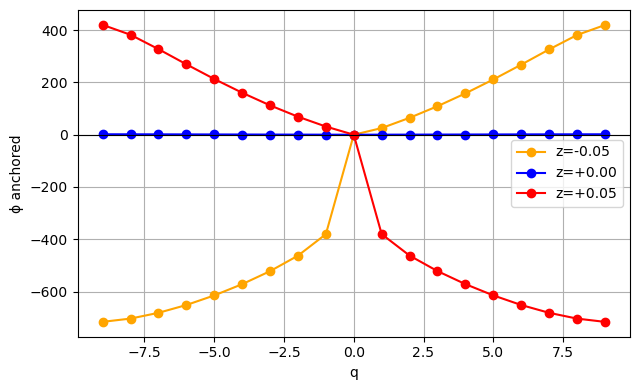

In [162]:
import numpy as np
import matplotlib.pyplot as plt

gamma   = 0.01
k       = 0.3
A       = 0.9
sigma   = 0.6

Q  = 9
Nz = 101
z_min, z_max = -0.05, 0.05
z_grid = np.linspace(z_min, z_max, Nz)

inv_grid = np.arange(-Q, Q+1)
Nq = len(inv_grid)

pref = A * k / (k - gamma)

phi = np.zeros((Nq, Nz))
relax = 0.2
tol = 1e-8

for _ in range(10000):
    phi_old = phi.copy()
    for iq,q in enumerate(inv_grid):
        row = phi[iq]
        delta_p = phi[iq+1]-row if iq<Nq-1 else np.inf
        delta_m = phi[iq-1]-row if iq>0 else np.inf

        drift = z_grid*q
        risk  = 0.5*gamma**2*sigma**2*q**2

        e_p = np.where(np.isfinite(delta_p),
                       np.exp(-gamma*delta_p) - 1, 0)
        e_m = np.where(np.isfinite(delta_m),
                       np.exp(-gamma*delta_m) - 1, 0)

        resid = drift - risk + pref*(e_p+e_m)
        phi[iq] = row - relax*resid
    phi[inv_grid==0] = 0.0
    print(np.max((np.abs(phi-phi_old))))
    if np.max(np.abs(phi-phi_old))<tol:
        print('converged ',_)
        break

plt.figure(figsize=(6.5,4))
for z,color in zip([-0.05,0.0,0.05],['orange','blue','red']):
    j=np.argmin(np.abs(z_grid - z))
    plt.plot(inv_grid,phi[:,j],marker='o',color=color,label=f"z={z:+.2f}")
plt.axhline(0,color='k',lw=0.8)
plt.xlabel("q");plt.ylabel("ϕ anchored");plt.legend();plt.grid(True);plt.tight_layout()


Reached max_iter without full convergence; max Δφ = 4.0e-06


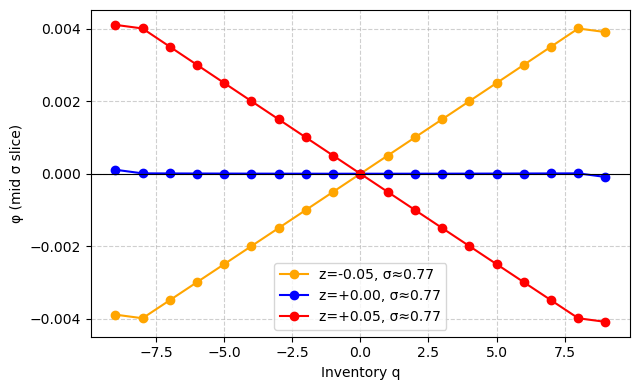

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# 1. Parameters
# ======================================================
gamma   = 0.005
k       = 10.0    # must be > gamma
A       = 0.3
sigma0  = 0.30          # central price vol
sigma_z = 0.02          # signal diffusion
nu      = 20      # vol-of-vol

# ======================================================
# 2. Grids
# ======================================================
Q          = 9
inv_grid   = np.arange(-Q, Q+1)        # inventory
Nq         = len(inv_grid)

Nz         = 101
z_min, z_max = -0.05, 0.05
z_grid     = np.linspace(z_min, z_max, Nz)
dz         = z_grid[1] - z_grid[0]

Ns         = 21
s_min, s_max = 0.1, 2.0
sig_grid   = np.linspace(s_min, s_max, Ns)
ds         = sig_grid[1] - sig_grid[0]

pref = A * k / (k - gamma)

# ======================================================
# 3. finite-diff matrices
# ======================================================
def D2_mat(N, h):
    main = -2*np.ones(N); main[0] = main[-1] = -1
    off  = np.ones(N-1)
    return (np.diag(main) + np.diag(off,1) + np.diag(off,-1)) / (h*h)

D2_sigma = D2_mat(Ns, ds)

# ======================================================
# 4. Initial phi and solver parameters
# ======================================================
phi   = np.zeros((Nq, Nz, Ns))
relax = 0.00001
tol   = 1e-6
max_iter = 1000
clip  = 10.0

# ======================================================
# 5. Fixed‑point minus‑update solver with σ and z diffusion
# ======================================================
for it in range(max_iter):
    phi_old = phi.copy()
    
    # ---- sigma derivatives (for nonlinear term) ----
    phi_s  = np.zeros_like(phi)
    phi_s[:,:,1:-1] = (phi[:,:,2:] - phi[:,:,:-2]) / (2*ds)
    phi_s[:,:,0]  = phi_s[:,:,1]
    phi_s[:,:,-1] = phi_s[:,:,-2]
    nonlin_sigma = 0.5 * nu**2 * gamma * phi_s**2   # shape (Nq,Nz,Ns)
    
    # ---- z derivatives ----
    phi_z  = np.zeros_like(phi)
    phi_z[:,1:-1,:] = (phi[:,2:,:] - phi[:,:-2,:]) / (2*dz)
    phi_z[:,0,:]  = phi_z[:,1,:]
    phi_z[:,-1,:] = phi_z[:,-2,:]
    nonlin_z = 0.5 * sigma_z**2 * gamma * phi_z**2  # shape (Nq,Nz,Ns)
    
    phi_zz = np.zeros_like(phi)
    phi_zz[:,1:-1,:] = (phi[:,2:,:] - 2*phi[:,1:-1,:] + phi[:,:-2,:]) / (dz*dz)
    # Neumann BC gives zero second deriv at edges
    lin_z = -0.5 * sigma_z**2 * phi_zz
    
    # main sweep over q,z
    for iq, q in enumerate(inv_grid):
        for jz, z in enumerate(z_grid):
            row_sigma = phi[iq, jz]                # vector length Ns
            
            # inventory jumps
            delta_p = phi[iq+1, jz] - row_sigma if iq < Nq-1 else np.inf
            delta_m = phi[iq-1, jz] - row_sigma if iq > 0    else np.inf
            
            # clip for exponent
            if np.isfinite(delta_p).any():
                delta_p = np.where(np.isfinite(delta_p),
                                   np.clip(delta_p, -clip, clip),
                                   delta_p)
            if np.isfinite(delta_m).any():
                delta_m = np.where(np.isfinite(delta_m),
                                   np.clip(delta_m, -clip, clip),
                                   delta_m)
            
            drift = z * q
            risk  = -0.5 * (gamma**2) * (sig_grid**2) * q**2
            
            # jump vectors
            e_p = np.where(np.isfinite(delta_p),
                           np.exp(-gamma*delta_p) - 1.0,
                           0.0)
            e_m = np.where(np.isfinite(delta_m),
                           np.exp(-gamma*delta_m) - 1.0,
                           0.0)
            jump = pref * (e_p + e_m)
            
            # linear sigma diffusion term
            lin_sigma = -0.5 * nu**2 * (D2_sigma @ row_sigma)
            
            residual = (drift
                        + risk
                        + jump
                        + nonlin_sigma[iq, jz]
                        + lin_sigma
                        + nonlin_z[iq, jz]
                        + lin_z[iq, jz])
            
            phi[iq, jz] = row_sigma - relax * residual
    
    # anchor at q=0
    kappa = 0.0001
    phi[0,:,:] = phi[1,:,:] + kappa
    phi[-1,:,:] = phi[-2,:,:] - kappa

    
    err = np.max(np.abs(phi - phi_old))
    if err < tol:
        print(f"Converged in {it+1} sweeps, max Δφ = {err:.1e}")
        break
else:
    print("Reached max_iter without full convergence; max Δφ = {:.1e}".format(err))
import h5py
with h5py.File("hjb_solution.h5","w") as f:
    f.create_dataset("phi", data=phi)
    f.create_dataset("inv_grid", data=inv_grid)
    f.create_dataset("z_grid", data=z_grid)
    f.create_dataset("sig_grid", data=sig_grid)

# ======================================================
# 6. Plot mid‑sigma slice
# ======================================================
mid_s = Ns // 3
plt.figure(figsize=(6.5,4))
for z,color in zip([-0.05,0.0,0.05],['orange','blue','red']):
    jz = np.argmin(np.abs(z_grid - z))
    plt.plot(inv_grid, phi[:, jz, mid_s], marker='o', color=color,
             label=f"z={z:+.2f}, σ≈{sig_grid[mid_s]:.2f}")
plt.axhline(0,color='k',lw=0.8)
plt.xlabel("Inventory q"); plt.ylabel("φ (mid σ slice)")
plt.legend(); plt.grid(True, ls='--', alpha=0.6); plt.tight_layout()


In [59]:
# -----------------------------------------------
# after φ has converged
# -----------------------------------------------
delta_p = np.full_like(phi, np.inf)         # q → q + 1  (ask)
delta_m = np.full_like(phi, np.inf)         # q → q - 1  (bid)

delta_p[:-1, :, :] = phi[1:, :, :] - phi[:-1, :, :]   # valid up to q = +Q-1
delta_m[1:,  :, :] = phi[:-1, :, :] - phi[1:,  :, :]  # valid down to q = –Q+1

with h5py.File("hjb_solution.h5", "w") as f:
    f.create_dataset("delta_p",  data=delta_p,  compression="gzip")
    f.create_dataset("delta_m",  data=delta_m,  compression="gzip")
    f.create_dataset("inv_grid", data=inv_grid)
    f.create_dataset("z_grid",   data=z_grid)
    f.create_dataset("sig_grid", data=sig_grid)
    # (optionally keep "phi" as well, but you don't have to)
print(phi[1:-1,:,:] - phi[0:-2,:,:])

[[[-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]
  [-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]
  [-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]
  ...
  [-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]
  [-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]
  [-1.00000000e-04 -1.00000000e-04 -1.00000000e-04 ... -1.00000000e-04
   -1.00000000e-04 -1.00000000e-04]]

 [[ 4.97901277e-04  4.97889334e-04  4.97865683e-04 ...  4.96672236e-04
    4.96632142e-04  4.96610526e-04]
  [ 4.87901502e-04  4.87889559e-04  4.87865907e-04 ...  4.86672460e-04
    4.86632366e-04  4.86610751e-04]
  [ 4.77901726e-04  4.77889783e-04  4.77866132e-04 ...  4.76672685e-04
    4.76632591e-04  4.76610975e-04]
  ...
  [-4.82076712e-04 -4.8

In [60]:
# assume phi.shape == (Nq, Nz, Ns)
Nq, Nz, Ns = phi.shape

# -------------------------------------------------------------------
# 1) your interior forward‑difference (ask side, q -> q+1)
# -------------------------------------------------------------------
#    shape will be (Nq-2, Nz, Ns)
inner_dp = phi[2:  , :, :] - phi[1:-1, :, :]   # iq = 1 … Nq-2
inner_dm = phi[0:-2  , :, :] - phi[1:-1, :, :] 
# -------------------------------------------------------------------
# 2) build a full‑size container and insert the interior
# -------------------------------------------------------------------
delta_p = np.empty_like(phi)      # (Nq, Nz, Ns)
delta_p[1:-1, :, :] = inner_dp    # fill iq = 1…Nq-2

delta_p = np.empty_like(phi)      # (Nq, Nz, Ns)
delta_p[1:-1, :, :] = inner_dp 

# -------------------------------------------------------------------
# 3) add the two edge layers however you want
# -------------------------------------------------------------------
# 3a.  UNREACHABLE ⇒ set to NaN
BIG = 1
delta_m[0 , :, :]  = +BIG     # selling lowers value a lot
delta_p[0 , :, :]  = -BIG     # buying raises value a lot

# q = +Q  (already long)      → forbid further buys
delta_p[-1, :, :] = +BIG      # buying lowers value a lot
delta_m[-1, :, :] = -BIG      # iq = Nq-1 (q = +Q): can't take q+1
# ----- OR choose one of these alternatives instead of NaN -----

# 3b.  COPY nearest interior value  (flat extrapolation)
# delta_p[0 , :, :] = delta_p[ 1, :, :]
# delta_p[-1, :, :] = delta_p[-2, :, :]

# 3c.  BIG constant to force a huge spread
# delta_p[0 , :, :] = 1e9
# delta_p[-1, :, :] = 1e9


g_over_k_minus_g = gamma / (k - gamma)

# ask (buy one lot)          δ⁺ large +ve  → wide spread (discourage)
ask_half = -(1.0/gamma) * (
    np.log1p( g_over_k_minus_g * np.exp(-gamma * delta_p) )
)

# bid (sell one lot)         δ⁻ large +ve → wide spread (discourage)
bid_half = -(1.0/gamma) * (
    np.log1p( g_over_k_minus_g * np.exp(-gamma * delta_m) )
)

'''ask_half = np.clip(ask_half, -BIG, BIG)
bid_half = np.clip(bid_half, -BIG, BIG)'''

# ---------------------------------------------------------
# save only what the quote engine needs
# ---------------------------------------------------------
with h5py.File("hjb_solution.h5", "w") as f:
    f.create_dataset("ask_half", data=ask_half, compression="gzip")
    f.create_dataset("bid_half", data=bid_half, compression="gzip")
    f.create_dataset("inv_grid", data=inv_grid)
    f.create_dataset("z_grid",   data=z_grid)
    f.create_dataset("sig_grid", data=sig_grid)

plt.show()

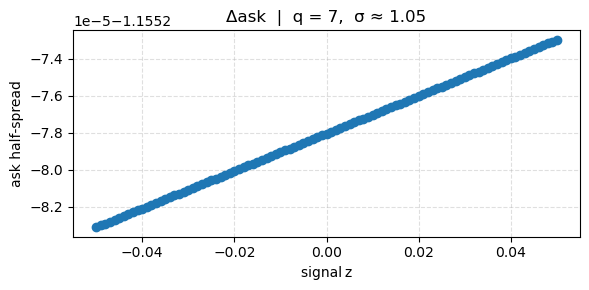

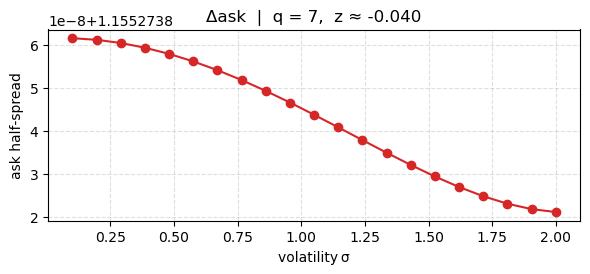

In [49]:

# ask_half shape: (Nq, Nz, Ns)

iq = 16       # choose the inventory slice you care about

# -------------------------------------------------
# 1)  Fix σ, sweep across z  (one 1‑D line)
# -------------------------------------------------
js = 10     # middle of the σ‑grid (or pick any index 0…Ns‑1)

plt.figure(figsize=(6,3))
plt.plot(z_grid, bid_half[iq, :, js], marker='o')
plt.xlabel("signal z")
plt.ylabel("ask half‑spread")
plt.title(f"Δask  |  q = {inv_grid[iq]},  σ ≈ {sig_grid[js]:.2f}")
plt.grid(alpha=0.4, ls="--")
plt.tight_layout()
plt.show()



# -------------------------------------------------
# 2)  Fix z, sweep across σ  (one 1‑D line)
# -------------------------------------------------
jz = 10      # middle of the z‑grid (or pick any index 0…Nz‑1)

plt.figure(figsize=(6,3))
plt.plot(sig_grid, ask_half[iq, jz, :], marker='o', color='tab:red')
plt.xlabel("volatility σ")
plt.ylabel("ask half‑spread")
plt.title(f"Δask  |  q = {inv_grid[iq]},  z ≈ {z_grid[jz]:+.3f}")
plt.grid(alpha=0.4, ls="--")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# ——— 1. Build the interpolator ———
# inv_grid, z_grid, sig_grid and phi are as in your solver
interp_phi = RegularGridInterpolator(
    (inv_grid, z_grid, sig_grid),
    phi,
    method="linear",
    bounds_error=False,
    fill_value=None
)

# ——— 2. Precompute the constant term ———
const_term = (1.0/gamma) * np.log(k/(k - gamma))

# ——— 3. Define bid and ask spread functions ———
def bid_spread(q, z, sigma):
    """
    Optimal bid spread δ_b*(q,z,σ).
    δ_b = 1/γ·ln(k/(k−γ)) + φ(q,z,σ) − φ(q+1,z,σ)
    """
    # nearest‐neighbour guard at max inventory
    if q >= inv_grid[-1]:
        return np.nan
    # interpolate φ at (q,z,σ) and (q+1,z,σ)
    φ_q   = interp_phi((q,   z, sigma))
    φ_qp1 = interp_phi((q+1, z, sigma))
    return const_term + (φ_qp1 - φ_q)


def ask_spread(q, z, sigma):
    """
    Optimal ask spread δ_a*(q,z,σ).
    δ_a = 1/γ·ln(k/(k−γ)) + φ(q,z,σ) − φ(q−1,z,σ)
    """
    # guard at min inventory
    if q <= inv_grid[0]:
        return np.nan
    φ_q   = interp_phi((q,   z, sigma))
    φ_qm1 = interp_phi((q-1, z, sigma))
    return const_term + (φ_qm1 - φ_q)





Optimal bid spread: 9.094481154825473e-06
Optimal ask spread: 3.9454811033217325


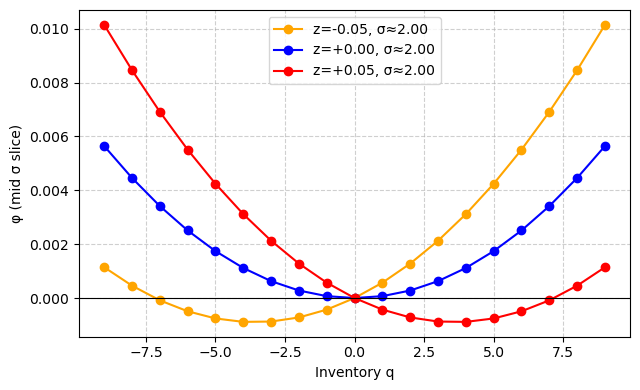

In [269]:
mid_s = 20
plt.figure(figsize=(6.5,4))
for z,color in zip([-0.05,0.0,0.05],['orange','blue','red']):
    jz = np.argmin(np.abs(z_grid - z))
    plt.plot(inv_grid, phi[:, jz, mid_s], marker='o', color=color,
             label=f"z={z:+.2f}, σ≈{sig_grid[mid_s]:.2f}")
plt.axhline(0,color='k',lw=0.8)
plt.xlabel("Inventory q"); plt.ylabel("φ (mid σ slice)")
plt.legend(); plt.grid(True, ls='--', alpha=0.6); plt.tight_layout()

In [ ]:
import numpy as np

# ---------- parameters ----------
gamma, k, A = 0.01, 0.30, 0.90
sigma_z, nu  = 0.02, 0.25
Q = 9
inv = np.arange(-Q, Q+1)
Nz = 101
z  = np.linspace(-0.05, 0.05, Nz); dz = z[1]-z[0]
Ns = 5
s  = np.linspace(0.30, 0.90, Ns); ds = s[1]-s[0]

pref = A*k/(k-gamma)
dσ   = 0.5*nu**2 / ds**2

GRAD_CLIP, Z_CLIP, MAX_DELTA = 20., 20., 4000.

phi      = np.zeros((len(inv), Nz, Ns))
c_plus   = np.ones((len(inv)-1, Nz, Ns))
c_minus  = np.ones((len(inv)-1, Nz, Ns))

def clip_grad(arr, clip):
    return np.clip(np.nan_to_num(arr, nan=0.0, posinf=clip, neginf=-clip), -clip, clip)

max_outer, tol = 30, 1e-6
history = []

for outer in range(max_outer):
    phi_old = phi.copy()
    try:
        for iq, q in enumerate(inv):
            # Policy function indexing adjustments for boundaries
            if iq == 0:  # q = -Q (left boundary)
                qp = phi[iq+1]
                qm = None
            elif iq == len(inv)-1:  # q = +Q (right boundary)
                qp = None
                qm = phi[iq-1]
            else:
                qp = phi[iq+1]
                qm = phi[iq-1]

            for jz, zz in enumerate(z):
                # Handle c_plus and c_minus at inventory boundaries
                if iq < len(inv)-1:
                    cp = c_plus[iq, jz]
                else:
                    cp = np.zeros(Ns)  # Right boundary: no c_plus
                
                if iq > 0:
                    cm = c_minus[iq-1, jz]
                else:
                    cm = c_minus[iq, jz]  # Left boundary: use forward difference for c_minus

                # Construct tridiagonal matrix
                main  = 2*dσ + cp + cm
                upper = -dσ - cp[:-1]
                lower = -dσ - cm[1:]
                main[0]  = dσ + cp[0]  + cm[0]
                main[-1] = dσ + cp[-1] + cm[-1]

                drift = zz * q
                risk  = -0.5 * (gamma**2) * s**2 * q**2
                const_jump = -pref * ((iq < len(inv)-1) + (iq > 0))

                # Compute gradients for s and z dimensions
                if Ns > 2:
                    s_grad = (phi[iq,jz,2:] - phi[iq,jz,:-2])/(2*ds)
                    s_grad = np.r_[s_grad[0], s_grad, s_grad[-1]]
                else:
                    s_grad = np.zeros(Ns)
                s_grad = clip_grad(s_grad, GRAD_CLIP)
                nonlin_sigma = 0.5*nu**2*gamma*s_grad**2

                if 0 < jz < Nz-1:
                    z_grad = (phi[iq,jz+1]-phi[iq,jz-1])/(2*dz)
                    z_grad = clip_grad(z_grad, Z_CLIP)
                    z_zz   = (phi[iq,jz+1]-2*phi[iq,jz]+phi[iq,jz-1])/(dz*dz)
                else:
                    z_grad = np.zeros(Ns)
                    z_zz   = np.zeros(Ns)
                nonlin_z = 0.5*sigma_z**2*gamma*z_grad**2
                lin_z    = -0.5*sigma_z**2*z_zz

                rhs = -(drift + risk + const_jump + nonlin_sigma + nonlin_z + lin_z)

                # Regularize matrix to avoid singularity
                A = np.diag(main + 1e-10) + np.diag(upper,1) + np.diag(lower,-1)

                # Solve tridiagonal system
                phi_new = np.linalg.solve(A, rhs)

                # Relaxation with smaller initial step
                theta = 0.01 if outer < 10 else 0.5
                phi[iq,jz] = (1-theta)*phi[iq,jz] + theta*phi_new
    except np.linalg.LinAlgError as err:
        print(f"Singular matrix at outer {outer}, q index {iq}, z index {jz}")
        print("main diag sample:", main)
        raise

    # Policy improvement with stabilized updates
    for iq in range(len(inv)-1):
        delta_plus = np.clip(phi[iq+1] - phi[iq], -MAX_DELTA, MAX_DELTA)
        c_plus[iq] = np.exp(-gamma * delta_plus)
        
        # For c_minus, use backward difference (iq-1 to iq)
        if iq > 0:
            delta_minus = np.clip(phi[iq] - phi[iq-1], -MAX_DELTA, MAX_DELTA)
            c_minus[iq-1] = np.exp(gamma * delta_minus)
        # Special case: left inventory boundary (iq=0)
        else:
            delta_minus = np.clip(phi[iq] - phi[iq+1], -MAX_DELTA, MAX_DELTA)  # Forward diff
            c_minus[iq] = np.exp(gamma * delta_minus)  # Store at iq (not iq-1)

    # Reset zero inventory to zero
    phi[inv==0] = 0.0
    
    # Check convergence
    diff = np.max(np.abs(phi - phi_old))
    history.append(diff)
    print(f"outer {outer:02d}  |Δφ|∞ = {diff:.2e}")
    if diff < tol:
        print("Converged at iteration", outer)
        break

# Output convergence history
history

outer 00  |Δφ|∞ = 5.08e+81
outer 01  |Δφ|∞ = 1.70e+85
outer 02  |Δφ|∞ = 2.95e+88
Singular matrix at outer 3, q index 9, z index 33
main diag sample: [nan nan nan nan nan]


/var/folders/nc/cnqlgv_511vdqq6c5n2pcfmm0000gn/T/ipykernel_90110/2290338842.py:78: RuntimeWarning:

overflow encountered in divide



LinAlgError: Singular matrix

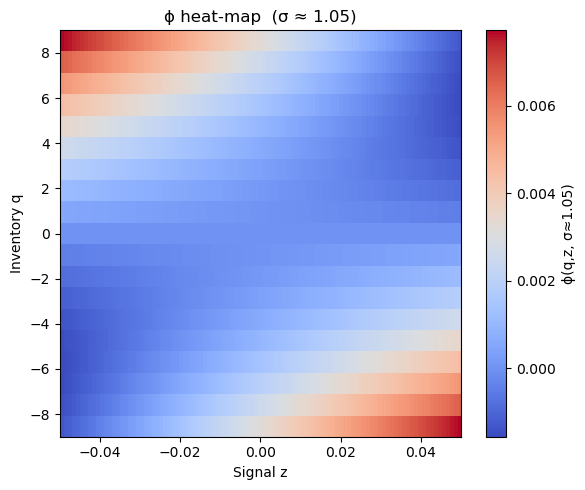

In [263]:
import matplotlib.pyplot as plt

# ---- CONFIG ----
plot_all_sigma_slices = False   # True = panel for every σ
cmap = "coolwarm"

if plot_all_sigma_slices:
    ncols = int(np.ceil(len(sig_grid) / 2))
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 8),
                             sharex=True, sharey=True)
    axes = axes.flatten()
    for idx, sig in enumerate(sig_grid):
        im = axes[idx].imshow(
                phi[:, :, idx],
                origin="lower", aspect="auto",
                extent=[z_grid[0], z_grid[-1], inv_grid[0], inv_grid[-1]],
                cmap=cmap)
        axes[idx].set_title(f"ϕ(q,z)  σ={sig:.2f}")
        axes[idx].set_xlabel("Signal z")
        axes[idx].set_ylabel("Inventory q")
        fig.colorbar(im, ax=axes[idx])
    plt.tight_layout()
else:
    mid_idx = len(sig_grid)//2
    sig_val = sig_grid[mid_idx]

    plt.figure(figsize=(6,5))
    plt.imshow(
        phi[:, :, mid_idx],
        origin="lower", aspect="auto",
        extent=[z_grid[0], z_grid[-1], inv_grid[0], inv_grid[-1]],
        cmap=cmap)
    plt.colorbar(label=f"ϕ(q,z, σ≈{sig_val:.2f})")
    plt.title(f"ϕ heat‑map  (σ ≈ {sig_val:.2f})")
    plt.xlabel("Signal z")
    plt.ylabel("Inventory q")
    plt.tight_layout()


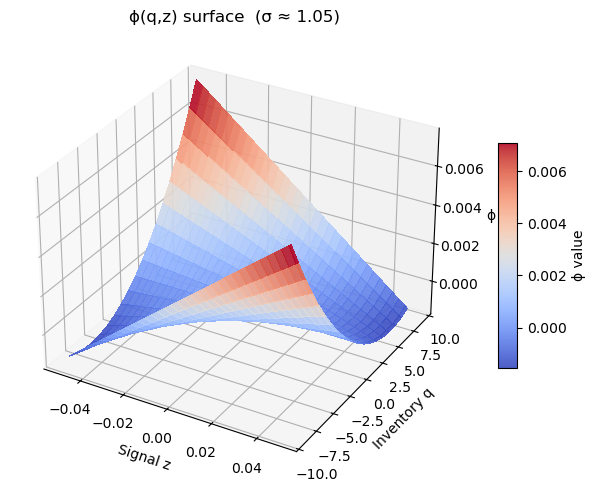

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - ensures 3D projection registration

# -------- assume phi, inv_grid, z_grid, sig_grid already in kernel --------
# choose σ slice
mid_idx = len(sig_grid) // 2
sig_val = sig_grid[mid_idx]

# Meshgrid for surface plot
Z, Q = np.meshgrid(z_grid, inv_grid)          # shape (Nq, Nz)
Phi_slice = phi[:, :, mid_idx]                # same shape

# 3D surface
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Z, Q, Phi_slice,
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.9)

ax.set_title(f"ϕ(q,z) surface  (σ ≈ {sig_val:.2f})")
ax.set_xlabel("Signal z")
ax.set_ylabel("Inventory q")
ax.set_zlabel("ϕ")
fig.colorbar(surf, shrink=0.5, aspect=12, label="ϕ value")

plt.tight_layout()



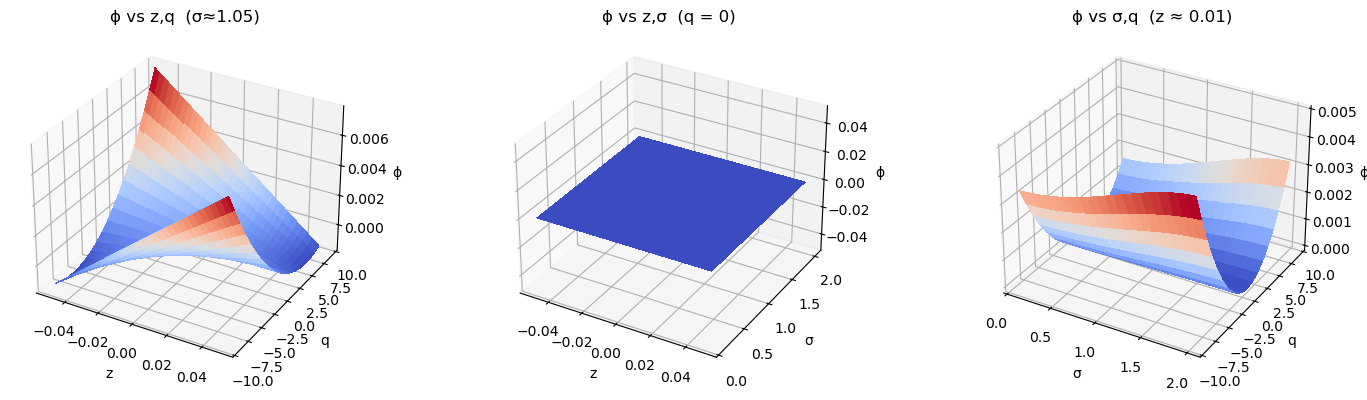

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # registers 3‑D projection

# choose central slices
mid_q = len(inv_grid)//3
mid_z = len(z_grid)//4
mid_s = len(sig_grid)//2

# meshgrids
ZQ_Z, ZQ_Q = np.meshgrid(z_grid, inv_grid)       # for (z,q)
ZS_Z, ZS_S = np.meshgrid(z_grid, sig_grid)       # for (z,σ)
SQ_S, SQ_Q = np.meshgrid(sig_grid, inv_grid)     # for (σ,q)

fig = plt.figure(figsize=(15,4))

# 1) ϕ(z,q) at mid σ
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax1.plot_surface(ZQ_Z, ZQ_Q, phi[:,:,mid_s],
                 cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_title(f"ϕ vs z,q  (σ≈{sig_grid[mid_s]:.2f})")
ax1.set_xlabel("z"); ax1.set_ylabel("q"); ax1.set_zlabel("ϕ")

b = 9
# ------------------------------------------------------------------
# panel 2  :  ϕ(z,σ) at mid q                (transpose DATA slice)
# ------------------------------------------------------------------
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.plot_surface(ZS_Z, ZS_S,           # meshes: shape (Ns, Nz)
                 phi[b, :, :].T,   # data  : shape (Ns, Nz) after .T
                 cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title(f"ϕ vs z,σ  (q = {inv_grid[b]})")
ax2.set_xlabel("z"); ax2.set_ylabel("σ"); ax2.set_zlabel("ϕ")

# ------------------------------------------------------------------
# panel 3  :  ϕ(σ,q) at mid z               (NO transpose needed)
# ------------------------------------------------------------------
n = 60
ax3 = fig.add_subplot(1,3,3, projection='3d')
ax3.plot_surface(SQ_S, SQ_Q,           # meshes: shape (Nq, Ns)
                 phi[:, n, :],     # data  : shape (Nq, Ns)
                 cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax3.set_title(f"ϕ vs σ,q  (z ≈ {z_grid[n]:.2f})")
ax3.set_xlabel("σ"); ax3.set_ylabel("q"); ax3.set_zlabel("ϕ")


plt.tight_layout()
plt.show()


In [188]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# --- ensure browser renderer if nbformat missing ---
pio.renderers.default = "browser"   # comment out if Jupyter inline works

# --- flatten data built by your solver -------------
Q, Z, S = np.meshgrid(inv_grid, z_grid, sig_grid, indexing="ij")
x = Z.ravel()
y = Q.ravel()
z = S.ravel()
val = phi.ravel()

# --- build isosurface ------------------------------
fig = go.Figure(go.Isosurface(
        x=x, y=y, z=z, value=val,
        colorscale="RdBu",
        opacity=0.5,
        surface_count=5,
        isomin=np.percentile(val, 20),
        isomax=np.percentile(val, 80),
        caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
        title="ϕ isosurfaces in (z, q, σ) space",
        scene=dict(
            xaxis_title="Signal z",
            yaxis_title="Inventory q",
            zaxis_title="Volatility σ",
            aspectmode="cube"
        ))

fig.show()


python(7565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [186]:
sig_grid

array([0.3 , 0.45, 0.6 , 0.75, 0.9 ])

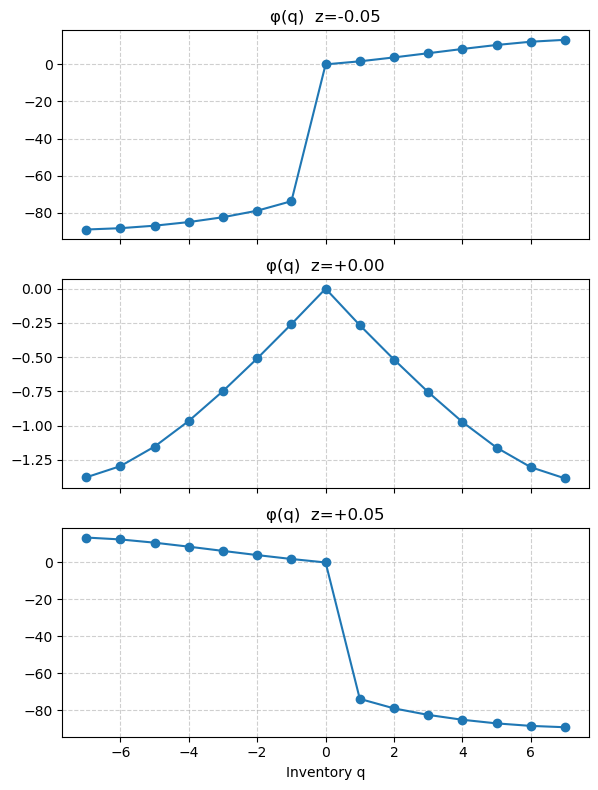

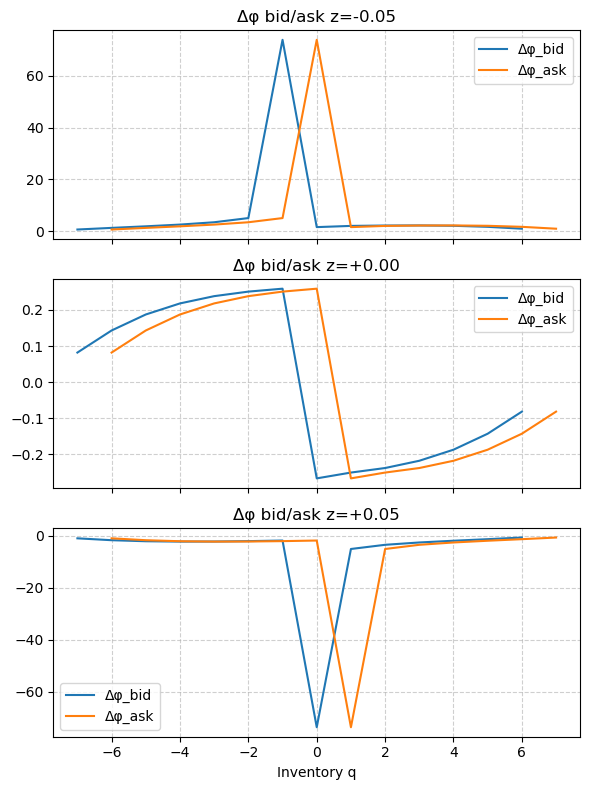

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# --------- parameters for "smooth but wrong direction" prototype ----------
gamma = 0.1
k     = 0.15
A     = 1.0
sigma = 0.1

Q = 7
inv = np.arange(-Q, Q+1)               # coarse grid
Nq  = len(inv)

z_vals = np.array([-0.05, 0.0, 0.05])
Nz = len(z_vals)

pref = A * k / (k - gamma)
const_spread = (1/gamma)*np.log(k/(k-gamma))

# explicit fixed‑point with WRONG SIGN update (row - λ*resid) and clipping
phi = np.zeros((Nq, Nz))
relax = 0.05
clip_val = 10.0
tol = 1e-6
max_iter = 10000

for it in range(max_iter):
    phi_old = phi.copy()
    for j, z in enumerate(z_vals):
        for iq, q in enumerate(inv):
            row = phi[iq, j]
            
            delta_p = phi[iq+1, j] - row if iq < Nq-1 else np.inf
            delta_m = phi[iq-1, j] - row if iq > 0     else np.inf
            
            if np.isfinite(delta_p):
                delta_p = np.clip(delta_p, -clip_val, clip_val)
            if np.isfinite(delta_m):
                delta_m = np.clip(delta_m, -clip_val, clip_val)
            
            drift = z * q
            risk  = 0.5 * gamma * sigma**2 * q**2
            jump  = pref * (
                (np.exp(-gamma*delta_p)-1 if np.isfinite(delta_p) else 0.0) +
                (np.exp(-gamma*delta_m)-1 if np.isfinite(delta_m) else 0.0)
            )
            residual = drift + risk + jump
            # -------- WRONG SIGN update (minus) ----------
            phi[iq, j] = row - relax * residual
    
    # anchor φ(0,z)=0
    phi[inv==0] = 0.0
    
    if np.max(np.abs(phi - phi_old)) < tol:
        break

# compute Δφ
delta_plus_phi  = phi[1:] - phi[:-1]
delta_minus_phi = phi[:-1] - phi[1:]

# ----------- plotting -----------
fig_phi, axes_phi = plt.subplots(3,1, figsize=(6,8), sharex=True)
fig_dphi, axes_dphi = plt.subplots(3,1, figsize=(6,8), sharex=True)
for idx, z in enumerate(z_vals):
    axes_phi[idx].plot(inv, phi[:, idx], marker='o')
    axes_phi[idx].set_title(f"φ(q)  z={z:+.02f}")
    axes_phi[idx].grid(True, ls='--', alpha=0.6)
    axes_dphi[idx].plot(inv[:-1], delta_plus_phi[:, idx], label='Δφ_bid')
    axes_dphi[idx].plot(inv[1:],  -delta_minus_phi[:, idx], label='Δφ_ask')
    axes_dphi[idx].set_title(f"Δφ bid/ask z={z:+.02f}")
    axes_dphi[idx].grid(True, ls='--', alpha=0.6)
    axes_dphi[idx].legend()

axes_phi[-1].set_xlabel("Inventory q")
axes_dphi[-1].set_xlabel("Inventory q")
fig_phi.tight_layout()
fig_dphi.tight_layout()


Howard iteration reached max_iter without converging.


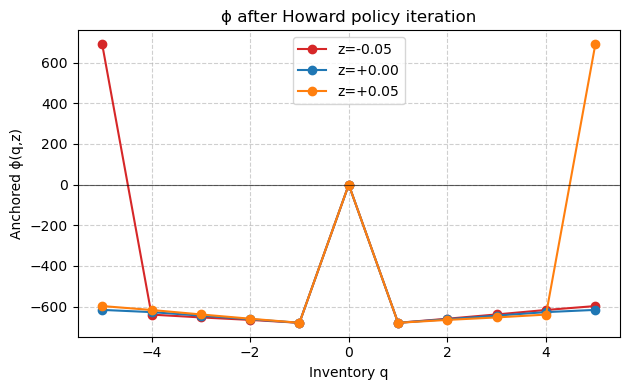

Sample optimal spreads (q=1):
 z=-0.05  δ_b(q=1)=31.0495  δ_a(q=1)=690.7755
 z=+0.00  δ_b(q=1)=28.6111  δ_a(q=1)=690.7755
 z=+0.05  δ_b(q=1)=25.2087  δ_a(q=1)=690.7755


In [ ]:
#!/usr/bin/env python3
"""Stoikov market–making policy iteration that is robust to any inventory grid size Q.

- All arrays are rebuilt every time the driver function is called, so you can
  change `Q` (or other parameters) safely between runs.
- The code uses *indices* to check whether we can buy/sell, instead of the
  parameter `Q` scattered throughout the loops.
- A small helper guards the sample‐spread printout so the script also runs when
  the grid does not contain `q = 1` (for example, if `Q < 1`).

Example
-------
>>> inv, z_vals, phi, d_b, d_a = stoikov_policy_iteration(Q=8)
>>> plot_phi(inv, z_vals, phi)
"""
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Union

__all__ = [
    "stoikov_policy_iteration",
    "plot_phi",
]


def stoikov_policy_iteration(
    Q: int = 17,
    *,
    gamma: float = 0.1,
    k: float = 0.15,
    A: float = 1.0,
    sigma: float = 0.02,
    z_vals: Union[np.ndarray, Sequence[float]] = (-0.05, 0.0, 0.05),
    max_iter: int = 1_000,
    eps_spread: float = 1e-6,
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Run Howard policy iteration for the finite‐inventory Stoikov model.

    Parameters
    ----------
    Q
        Half‐width of the inventory grid (grid is ``[-Q, …, +Q]``).
    gamma, k, A, sigma
        Model parameters (risk aversion, convexity, intensity scale, price
        volatility).
    z_vals
        1‑D array (or sequence) of latent‐signal slices at which to solve the
        Bellman equations.
    max_iter, eps_spread
        Stopping criteria for the Howard iteration.
    verbose
        If *True*, print a convergence message.

    Returns
    -------
    inv, z_vals, phi, delta_b, delta_a
        Inventory grid, signal grid, value function ``phi(inv, z)``, and the
        optimal bid/ask spreads for each state.
    """
    # ---------------- inventory & signal grids ----------------
    inv: np.ndarray = np.arange(-Q, Q + 1)
    z_vals = np.asarray(z_vals, dtype=float)

    Nq, Nz = len(inv), len(z_vals)

    # ---------------- helper constants ----------------
    const_spread = (1.0 / gamma) * np.log(k / (k - gamma))

    # initial policy (symmetric across q and z)
    delta_b = np.full((Nq, Nz), const_spread)
    delta_a = np.full((Nq, Nz), const_spread)

    # ---------------- Howard policy iteration ----------------
    for it in range(max_iter):
        # ---- policy evaluation ----
        v = np.zeros((Nq, Nz))  # v_q = exp(-gamma * phi_q)
        idx0 = np.where(inv == 0)[0][0]
        v[idx0, :] = 1.0  # anchor at q = 0 so the system has a solution

        for j, z in enumerate(z_vals):
            # Build the tri‑diagonal linear system A v = rhs.
            A_mat = np.zeros((Nq, Nq))
            rhs = np.zeros(Nq)

            # Anchor row (q = 0)
            A_mat[idx0, idx0] = 1.0
            rhs[idx0] = 1.0

            # Remaining rows
            for iq in range(Nq):
                if iq == idx0:
                    continue  # anchor handled above

                q = inv[iq]

                can_buy: bool = iq < Nq - 1  # q < +Q
                can_sell: bool = iq > 0      # q > -Q

                lam_b = cb = 0.0
                lam_a = ca = 0.0

                if can_buy:
                    lam_b = A * np.exp(-k * delta_b[iq, j])
                    cb = lam_b * np.exp(-gamma * delta_b[iq, j])

                if can_sell:
                    lam_a = A * np.exp(-k * delta_a[iq, j])
                    ca = lam_a * np.exp(-gamma * delta_a[iq, j])

                a = cb  # coefficient of v_{q+1}
                c = ca  # coefficient of v_{q-1}
                b = z * q + 0.5 * gamma * sigma ** 2 * q * q - (lam_b + lam_a)

                A_mat[iq, iq] = b
                if can_buy:
                    A_mat[iq, iq + 1] = a
                if can_sell:
                    A_mat[iq, iq - 1] = c

            # Solve A v = rhs for this particular z
            v[:, j] = np.linalg.solve(A_mat, rhs)

        # ---- policy improvement ----
        phi = -np.log(np.clip(v, 1e-30, None)) / gamma  # avoid log(0)

        delta_b_new = np.full_like(delta_b, np.nan)
        delta_a_new = np.full_like(delta_a, np.nan)

        for iq in range(Nq):
            if iq < Nq - 1:  # can move to q+1 (buy)
                delta_b_new[iq, :] = const_spread + (phi[iq + 1, :] - phi[iq, :])
            if iq > 0:      # can move to q‑1 (sell)
                delta_a_new[iq, :] = const_spread + (phi[iq - 1, :] - phi[iq, :])

        change = np.nanmax(np.abs(delta_b_new - delta_b))
        delta_b, delta_a = delta_b_new, delta_a_new

        if change < eps_spread:
            if verbose:
                print(f"Policy converged in {it + 1} iterations, max Δspread = {change:.2e}")
            break
    else:
        if verbose:
            print("Howard iteration reached max_iter without converging.")

    return inv, z_vals, phi, delta_b, delta_a


def plot_phi(inv: np.ndarray, z_vals: np.ndarray, phi: np.ndarray) -> None:
    """Quick Matplotlib helper to visualise ``phi(q, z)`` for every z‐slice."""
    plt.figure(figsize=(6.4, 4))
    colours = [
        "tab:red",
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:purple",
    ]
    for j, z in enumerate(z_vals):
        plt.plot(inv, phi[:, j], marker="o", color=colours[j % len(colours)], label=f"z={z:+.2f}")
    plt.axhline(0, color="k", lw=0.8, alpha=0.6)
    plt.grid(True, ls="--", alpha=0.6)
    plt.xlabel("Inventory q")
    plt.ylabel("Anchored ϕ(q,z)")
    plt.title("ϕ after Howard policy iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Demo run with the original parameters
    inv, z_vals, phi, delta_b, delta_a = stoikov_policy_iteration(Q=5)
    plot_phi(inv, z_vals, phi)

    # ---- sample optimal spreads for q = 1 (if present) ----
    if 1 in inv:
        print("Sample optimal spreads (q=1):")
        idx_q1 = np.where(inv == 1)[0][0]
        for j, z in enumerate(z_vals):
            print(
                f" z={z:+.2f}  δ_b(q=1)={delta_b[idx_q1, j]:.4f}  "
                f"δ_a(q=1)={delta_a[idx_q1, j]:.4f}"
            )
    else:
        print("Grid does not contain q = 1; choose a larger Q if you need that sample.")


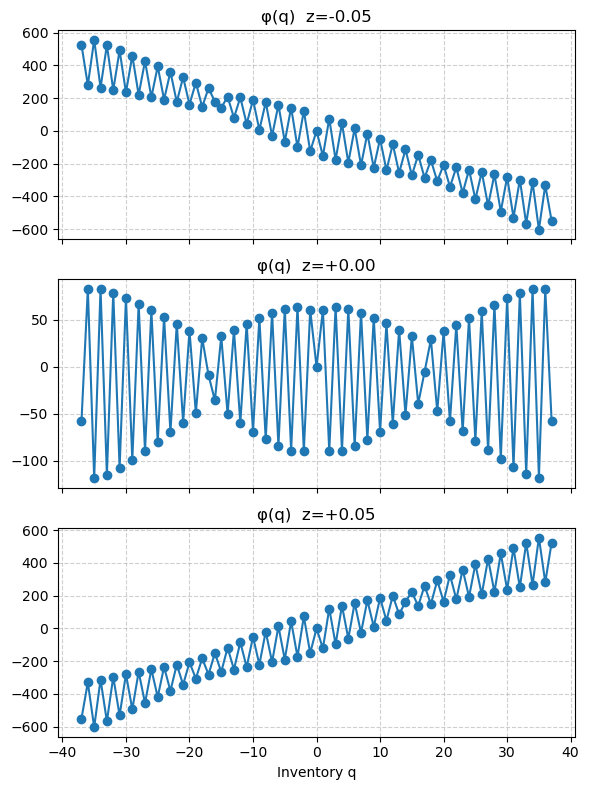

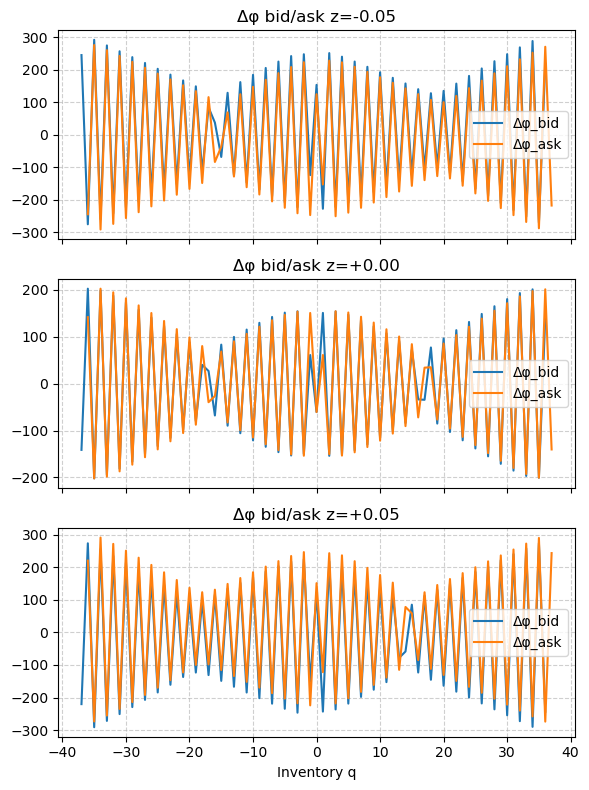

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------- parameters for "smooth but wrong direction" prototype ----------
gamma = 0.035
k     = 0.6
A     = 0.9
sigma = .025

Q = 37
inv = np.arange(-Q, Q+1)               # coarse grid
Nq  = len(inv)

z_vals = np.array([-0.05, 0.0, 0.05])
Nz = len(z_vals)

pref = A * k / (k - gamma)
const_spread = (1/gamma)*np.log(k/(k-gamma))

# explicit fixed‑point with CORRECTED SIGN update (row + λ*resid) and clipping
phi = np.zeros((Nq, Nz))
relax = 0.05
clip_val = 10.0
tol = 1e-6
max_iter = 5000

for it in range(max_iter):
    phi_old = phi.copy()
    for j, z in enumerate(z_vals):
        for iq, q in enumerate(inv):
            row = phi[iq, j]
            
            delta_p = phi[iq+1, j] - row if iq < Nq-1 else np.inf
            delta_m = phi[iq-1, j] - row if iq > 0     else np.inf
            
            if np.isfinite(delta_p):
                delta_p = np.clip(delta_p, -clip_val, clip_val)
            if np.isfinite(delta_m):
                delta_m = np.clip(delta_m, -clip_val, clip_val)
            
            drift = z * q
            risk  = -0.5 * gamma * sigma**2 * q**2  # FIXED SIGN (negative)
            jump  = pref * (  # FIXED SIGN (1 - exp(gamma*Δ))
                (1 - np.exp(gamma*delta_p) if np.isfinite(delta_p) else 0.0) +
                (1 - np.exp(gamma*delta_m) if np.isfinite(delta_m) else 0.0)
            )
            residual = drift + risk + jump
            # -------- CORRECTED SIGN update (plus) ----------
            phi[iq, j] = row + relax * residual  # FIXED SIGN (plus)
    
    # anchor φ(0,z)=0
    phi[inv==0] = 0.0
    
    if np.max(np.abs(phi - phi_old)) < tol:
        print('converged')
        break

# compute Δφ WITH CORRECTED SIGNS
delta_plus_phi  = phi[:-1] - phi[1:]   # φ(q)-φ(q+1) for bid spread
delta_minus_phi = phi[1:] - phi[:-1]   # φ(q+1)-φ(q) for ask spread

# ----------- plotting -----------
fig_phi, axes_phi = plt.subplots(3,1, figsize=(6,8), sharex=True)
fig_dphi, axes_dphi = plt.subplots(3,1, figsize=(6,8), sharex=True)
for idx, z in enumerate(z_vals):
    axes_phi[idx].plot(inv, phi[:, idx], marker='o')
    axes_phi[idx].set_title(f"φ(q)  z={z:+.02f}")
    axes_phi[idx].grid(True, ls='--', alpha=0.6)
    
    # Plot bid spread: φ(q)-φ(q+1) at inventory q
    axes_dphi[idx].plot(inv[:-1], delta_plus_phi[:, idx], label='Δφ_bid')
    # Plot ask spread: φ(q+1)-φ(q) at inventory q+1 (shifted)
    axes_dphi[idx].plot(inv[1:],  delta_minus_phi[:, idx], label='Δφ_ask')
    
    axes_dphi[idx].set_title(f"Δφ bid/ask z={z:+.02f}")
    axes_dphi[idx].grid(True, ls='--', alpha=0.6)
    axes_dphi[idx].legend()

axes_phi[-1].set_xlabel("Inventory q")
axes_dphi[-1].set_xlabel("Inventory q")
fig_phi.tight_layout()
fig_dphi.tight_layout()
plt.show()

Reached max_iter without full convergence


AttributeError: 'numpy.ndarray' object has no attribute 'tight_layout'

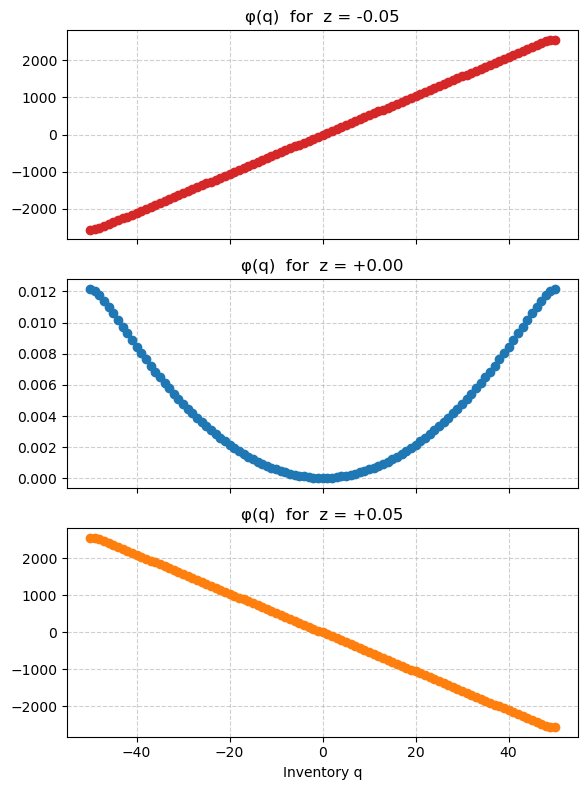

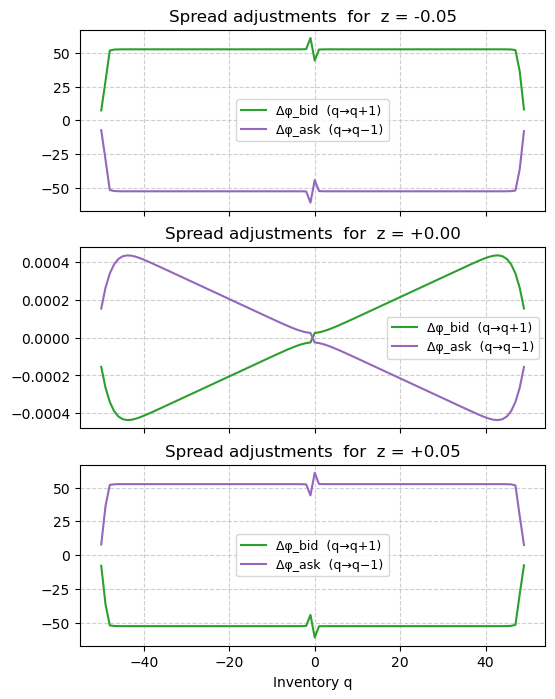

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================
# 1.  Model parameters  (k > gamma is mandatory)
# ==============================================
gamma = 0.01         # risk aversion
k     = 0.3           # depth parameter  > gamma
A     = 0.90           # intensity scale
sigma = 0.01         # price volatility

# ==============================================
# 2.  Grids
# ==============================================
Q  = 50                              # max inventory (±Q)
inv = np.arange(-Q, Q+1)               # q-grid  [-Q … +Q]
Nq  = len(inv)

z_vals = np.array([-0.05, 0.0, 0.05])  # three signal slices
Nz     = len(z_vals)

# positive prefactor  A k/(k-γ)
pref = A * k / (k - gamma)

# ==============================================
# 3.  Fixed-point solver (minus-update scheme)
# ==============================================
phi      = np.zeros((Nq, Nz))   # initial guess
relax    = 0.07                 # step size for residual update
clip_val = 10.0                 # clip Δφ to avoid overflow
tol      = 1e-8
max_iter = 15000

for it in range(max_iter):
    phi_old = phi.copy()

    for j, z in enumerate(z_vals):
        for iq, q in enumerate(inv):
            row = phi[iq, j]

            # forward/backward differences Δφ
            delta_p = phi[iq + 1, j] - row if iq < Nq - 1 else np.inf
            delta_m = phi[iq - 1, j] - row if iq > 0      else np.inf

            # clip for numerical safety
            if np.isfinite(delta_p):
                delta_p = np.clip(delta_p, -clip_val, clip_val)
            if np.isfinite(delta_m):
                delta_m = np.clip(delta_m, -clip_val, clip_val)

            # residual components  (all scalar arrays of length Nz=3 here)
            drift = z * q                                     #  + zq
            risk  = -0.5 * (gamma**2) * sigma**2 * q**2      #  - ½ γ² σ² q²

            jump = pref * (
                (np.exp(-gamma * delta_p) - 1.0 if np.isfinite(delta_p) else 0.0) +
                (np.exp(-gamma * delta_m) - 1.0 if np.isfinite(delta_m) else 0.0)
            )

            residual = drift + risk + jump

            # -------- minus-update (consistent with F' < 0) --------
            phi[iq, j] = row - relax * residual

    # anchor each slice at q = 0
    phi[inv == 0] = 0.0

    # convergence check
    if np.max(np.abs(phi - phi_old)) < tol:
        print(f"Converged in {it+1} iterations, tol={tol}")
        break
else:
    print("Reached max_iter without full convergence")

# ==============================================
# 4.  Compute Δφ for bid / ask spreads
#     (bid uses Δ⁺ = φ(q+1)−φ(q),
#      ask uses Δ⁻ = φ(q)−φ(q−1)  ⇒  −Δ⁻ = φ(q)−φ(q−1))
# ==============================================
delta_plus_phi  = phi[1:] - phi[:-1]       # shape (Nq-1, Nz)
delta_minus_phi = phi[:-1] - phi[1:]       # same magnitude, opposite sign

# ==============================================
# 5.  Plots
# ==============================================
fig_phi, axes_phi = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
fig_dphi, axes_dp = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
colors = ["tab:red", "tab:blue", "tab:orange"]

for idx, (z, col) in enumerate(zip(z_vals, colors)):
    # ---- φ(q) ----
    axes_phi[idx].plot(inv, phi[:, idx], marker="o", color=col)
    axes_phi[idx].set_title(f"φ(q)  for  z = {z:+.02f}")
    axes_phi[idx].grid(True, ls="--", alpha=0.6)

    # ---- Δφ bid / ask ----
    axes_dp[idx].plot(inv[:-1], delta_plus_phi[:, idx],
                      label="Δφ_bid  (q→q+1)", color="tab:green")
    axes_dp[idx].plot(inv[:-1], delta_minus_phi[:, idx],
                      label="Δφ_ask  (q→q−1)", color="tab:purple")
    axes_dp[idx].set_title(f"Spread adjustments  for  z = {z:+.02f}")
    axes_dp[idx].grid(True, ls="--", alpha=0.6)
    axes_dp[idx].legend(loc="best", fontsize=9)

axes_phi[-1].set_xlabel("Inventory q")
axes_dp[-1].set_xlabel("Inventory q")
fig_phi.tight_layout()
#axes_dp.tight_layout()

plt.show()
